In [6]:
from collections import Counter

In [1]:
obj1 = """THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM
SHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS
PROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE
WITH PERMISSION."""
obj2 = """ELECTRONIC AND MACHINE READABLE COPIES MAY BE
DISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS
PERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED
COMMERCIALLY."""
obj3 = """PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY
SERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP."""

documents = [obj1, obj2, obj3]

In [2]:
# construct word set from documents
words = set()
for obj in documents:
    tokens = obj.strip().replace(",", "").replace(".", "").split()
    for w in tokens:
        words.add(w)

print("Size of word set:", len(words))

Size of word set: 60


In [7]:
# construct bipartite graph
# 1. assign index to each element
words_lst = sorted(list(words))
word2embed = {w:i for i, w in enumerate(words_lst)}
# number of words
n1 = len(words_lst)
# number of objects (documents or images)
n2 = len(documents)

edges = set()
for i, obj in enumerate(documents):
    tokens = obj.strip().replace(",", "").replace(".", "").split()
    for w in tokens:
        j = word2embed.get(w, None)
        if j is None:
            raise ValueError
        # edge from j-th word into i-th document
        edges.add((i, j))

print("Size of edges:", len(edges))


edges_lst = sorted(list(edges))
cnt = Counter()
for i, j in edges_lst:
    cnt[i] += 1
print(cnt)

Size of edges: 65
Counter({0: 26, 1: 25, 2: 14})


In [ ]:
# cost function of documents
costs_of_docs = []


# Ideal Model

In [41]:
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from typing import List, Callable, Set
from itertools import accumulate, pairwise
import bisect
import numpy as np
from copy import deepcopy

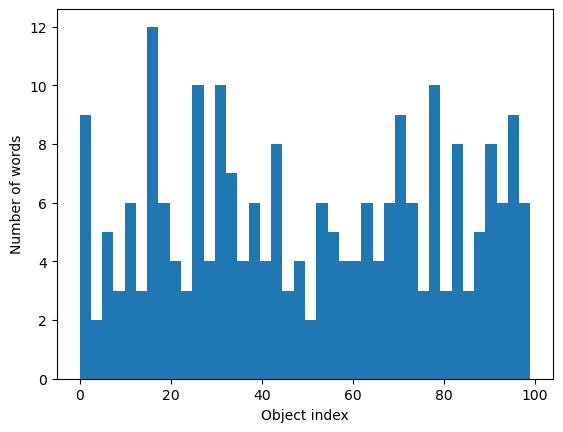

In [2]:


# number of words
n1 = 100
# number of objects
n2 = 100
# relation probability
p = 0.02
random.seed(1)
words = [i for i in range(n1)]
objects = [i for i in range(n2)]
edges = []
obj2words = defaultdict(set)

for obj in objects:
    for wrd in words:
        if random.random() <= p:
            edges.append((obj, wrd))
            obj2words[obj].add(wrd)


# cnt = Counter()
# for obj, wrd in edges:
#     cnt[obj] += 1

# print(cnt)



ttt = [x[0] for x in edges]
plt.hist(ttt, bins=40, density=False)
plt.ylabel("Number of words")
plt.xlabel("Object index")
plt.show()

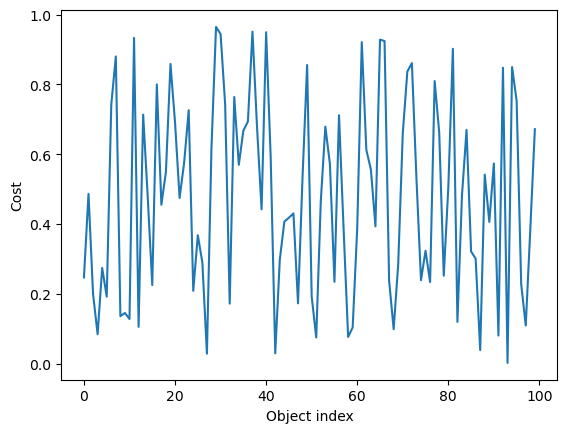

In [3]:
# cost function: object -> real value
costs_obj = [random.random() for i in range(n2)]

plt.plot(costs_obj)
plt.ylabel("Cost")
plt.xlabel("Object index")
plt.show()

In [9]:
# submodular objective
def objective(S: List[int]):
    res = set()
    for obj in S:
        res = res.union( obj2words[obj] )
    return len(res)

def marginal_gain(f: Callable, single: int, base: List[int]):
    if len(base) == 0:
        base2 = [single]
    else:
        base2 = list(set(list(base) + [single]))
    fS1 = f(base)
    fS2 = f(base2)
    return fS2 - fS1

def density(f: Callable, single: int, base: List[int]):
    mg = marginal_gain(f, single, base)
    cost = costs_obj[single]
    return (mg * 100) / (cost * 100)


def cost_of_set(S: List[int]):
    return sum(costs_obj[x] for x in S)

# test submodularity
x = [1,2,3,4,5,7,8,50,60,80]
for i in range(1, len(x) + 1):
    S = x[:i]
    # fS2 = objective(S + [6])
    # fS1 = objective(S)
    # marginal_gain = fS2 - fS1
    mg = marginal_gain(objective, 6, S)
    print("Input: {} U {{6}} -> Output: {}".format(S, mg))


Input: [1] U {6} -> Output: 1
Input: [1, 2] U {6} -> Output: 1
Input: [1, 2, 3] U {6} -> Output: 1
Input: [1, 2, 3, 4] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5, 7] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5, 7, 8] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5, 7, 8, 50] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5, 7, 8, 50, 60] U {6} -> Output: 1
Input: [1, 2, 3, 4, 5, 7, 8, 50, 60, 80] U {6} -> Output: 1


In [11]:
# algorithm

def greedy(V: List[int], b: float = 1.0):
    sol = set()
    remaining_elements = set(V)
    cur_cost = 0.
    while len(remaining_elements):
        # 
        u, max_density = None, -1.
        for e in remaining_elements:
            # e is an object
            # mg = marginal_gain(objective, e, sol)
            # density = (mg * 100) / (costs_obj[e] * 100)  # cost may be too small
            ds = density(objective, e, sol)
            if ds > max_density:
                u, max_density = e, ds
        #TODO: filter out violating elements
        assert u is not None
        if cur_cost + costs_obj[u] <= b:
            sol.add(u)
            cur_cost += costs_obj[u]
        remaining_elements.remove(u)
    return sol
        
        

sol = greedy(objects, 1.0)
print("Greedy Solution: size->{}, value->{}, cost->{}".format(len(sol), objective(sol), cost_of_set(sol)))

Greedy Solution: size->10, value->25, cost->0.9920030793907625


In [12]:
# algorithm

def modified_greedy(V: List[int], b: float = 1.0):
    sol = set()
    remaining_elements = set(V)
    cur_cost = 0.
    while len(remaining_elements):
        # 
        u, max_density = None, -1.
        for e in remaining_elements:
            # e is an object
            ds = density(objective, e, sol)
            if ds > max_density:
                u, max_density = e, ds
        #TODO: filter out violating elements
        assert u is not None
        if cur_cost + costs_obj[u] <= b:
            sol.add(u)
            cur_cost += costs_obj[u]
        remaining_elements.remove(u)

    v_star, v_star_fv = None, -1
    for e in V:
        fv = objective([e])
        if fv > v_star_fv:
            v_star, v_star_fv = e, fv

    sol_fv = objective(list(sol))
    if v_star_fv > sol_fv:
        return set([v_star])
    else:
        return sol

sol = modified_greedy(objects, 1.0)
print("Greedy Solution: size->{}, value->{}, cost->{}".format(len(sol), objective(sol), cost_of_set(sol)))

Greedy Solution: size->10, value->25, cost->0.9920030793907625


In [24]:
# algorithm
# implement upper bound mentioned in revisiting original paper

def marginal_delta(base_set: Set[int], remaining_set: Set[int], b: float):
    t = list(remaining_set)
    t.sort(key=lambda x: density(objective, x, base_set), reverse=True)
    costs = [costs_obj[x] for x in t]
    cumsum_costs = list(accumulate(costs, initial=None))
    # cumsum_costs[i] = sum(costs[:i])  exclusive
    # idx = bisect.bisect_left(cumsum_costs, b)
    # cumsum_costs[:idx]: x < b
    # cumsum_costs[idx:]: x >= b
    idx = bisect.bisect_right(cumsum_costs, b)
    # cumsum_costs[:idx]: x <= b
    # cumsum_costs[idx:]: x > b
    r = idx
    
    delta = 0.
    for i in range(r):
        # t[i] is a single element
        delta += marginal_gain(objective, t[i], base_set)

    # if cumsum_costs[-1] <= b, idx = len(cumsum_costs) - 1, no interpolation term
    if r < len(cumsum_costs): 
        c_star = cumsum_costs[r - 1]
        coefficient = (b - c_star) / costs_obj[t[r]]
        delta += marginal_gain(objective, t[r], base_set) * coefficient
    return delta
  

def modified_greedy_ub1(V: List[int], b: float = 1.0):
    sol = set()
    remaining_elements = set(V)
    cur_cost = 0.
    lambda_capital = float('inf')
    while len(remaining_elements):
        # 
        u, max_density = None, -1.
        for e in remaining_elements:
            # e is an object
            ds = density(objective, e, sol)
            if ds > max_density:
                u, max_density = e, ds
        #TODO: filter out violating elements
        assert u is not None
        if cur_cost + costs_obj[u] <= b:
            sol.add(u)
            cur_cost += costs_obj[u]
            # update data-dependent upper-bound
            lambda_capital = min(lambda_capital, objective(sol) + marginal_delta(sol, remaining_elements, b))
        remaining_elements.remove(u)

    v_star, v_star_fv = None, -1
    for e in V:
        fv = objective([e])
        if fv > v_star_fv:
            v_star, v_star_fv = e, fv

    sol_fv = objective(list(sol))
    if v_star_fv > sol_fv:
        return set([v_star]), v_star_fv, lambda_capital
    else:
        return sol, sol_fv, lambda_capital
    
sol, sol_fv, lambda_capital = modified_greedy_ub1(objects, 1.0)
print("Greedy Solution: size->{}, value->{}, cost->{}, lambda->{}, alpha->{}".format(len(sol), sol_fv, cost_of_set(sol), lambda_capital, sol_fv / lambda_capital))

Greedy Solution: size->10, value->25, cost->0.9920030793907625, lambda->25.0, alpha->1.0


In [42]:
# algorithm
# implement newly designed upper bound 


    
sol, sol_fv, lambda_capital = modified_greedy_ub2(objects, 1.0)
print("Greedy Solution: size->{}, value->{}, cost->{}, lambda->{}, alpha->{}".format(len(sol), sol_fv, cost_of_set(sol), lambda_capital, sol_fv / lambda_capital))

Greedy Solution: size->10, value->25, cost->0.9920030793907625, lambda->25.0, alpha->1.0


# Experiments
1. budget: 0.5, 0.8, 

In [45]:
# for budget in 
interval = 0.3
num_points = 20
start_point = 0.5
end_point = start_point + (num_points - 1) * interval
bds = np.linspace(start=start_point, stop=end_point, num=num_points)
ys_up1 = []
ys_up2 = []
for budget in bds:
    sol, sol_fv, lambda_capital = modified_greedy_ub1(objects, budget)
    ys_up1.append(sol_fv / lambda_capital)
    sol, sol_fv, lambda_capital = modified_greedy_ub2(objects, budget)
    ys_up2.append(sol_fv / lambda_capital)

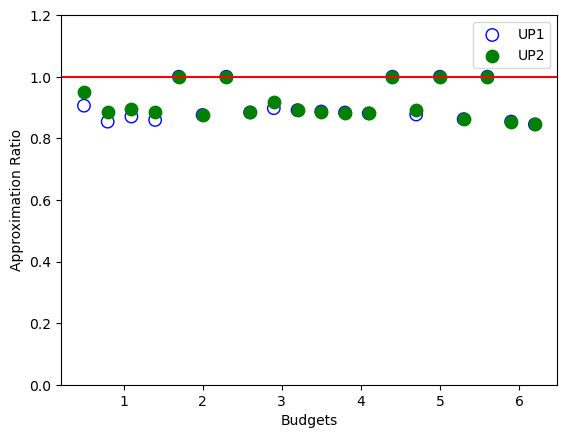

In [46]:
plt.scatter(bds, ys_up1, s=80, facecolors='none', edgecolors='b', label='UP1')
plt.scatter(bds, ys_up2, s=80, facecolors='g', edgecolors='g', label='UP2')
plt.xlabel("Budgets")
plt.ylabel("Approximation Ratio")
plt.ylim([0., 1.2])
plt.axhline(y = 1.0, color='r', linestyle='-')
plt.legend()
plt.show()